# Семинар №3
### Калашников Дмитрий, 27.02

Что происходит в ноутбуке:
1. Предобучение BERT
2. Fine-tuning BERT
3. RAG

## BERT Pre-train

In [ ]:
!wget https://github.com/touhi99/Chatbot-seq2seq-movie-dataset/archive/refs/heads/master.zip
!mkdir datasets
!mv master.zip datasets/
!unzip datasets/master.zip -d datasets/
!ls datasets

In [42]:
!head datasets/Chatbot-seq2seq-movie-dataset-master/movie_conversations.txt

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L205', 'L206']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L271', 'L272', 'L273', 'L274', 'L275']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L276', 'L277']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L280', 'L281']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L363', 'L364']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L365', 'L366']


In [43]:
!head datasets/Chatbot-seq2seq-movie-dataset-master/movie_lines.txt

L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!
L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.
L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?
L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.
L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow
L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.
L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No
L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I'm kidding.  You know how sometimes you just become this "persona"?  And you don't know how to quit?
L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?


Вдохновились результатами из этой статьи 

https://medium.com/data-and-beyond/complete-guide-to-building-bert-model-from-sratch-3e6562228891

In [44]:
import os
from pathlib import Path
import torch
import re
import random
import transformers, datasets
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
import tqdm
from torch.utils.data import Dataset, DataLoader
import itertools
import math
import torch.nn.functional as F
import numpy as np
from torch.optim import Adam

MAX_LEN = 64

### loading all data into memory

corpus_movie_conv = 'datasets/Chatbot-seq2seq-movie-dataset-master/movie_conversations.txt'
corpus_movie_lines = 'datasets/Chatbot-seq2seq-movie-dataset-master/movie_lines.txt'
with open(corpus_movie_conv, 'r', encoding='iso-8859-1') as c:
    conv = c.readlines()
with open(corpus_movie_lines, 'r', encoding='iso-8859-1') as l:
    lines = l.readlines()

### splitting text using special lines
lines_dic = {}
for line in lines:
    objects = line.split(" +++$+++ ")
    lines_dic[objects[0]] = objects[-1]

### generate question answer pairs
pairs = []
for con in conv:
    ids = eval(con.split(" +++$+++ ")[-1])
    for i in range(len(ids)):
        qa_pairs = []
        
        if i == len(ids) - 1:
            break

        first = lines_dic[ids[i]].strip()  
        second = lines_dic[ids[i+1]].strip() 

        qa_pairs.append(' '.join(first.split()[:MAX_LEN]))
        qa_pairs.append(' '.join(second.split()[:MAX_LEN]))
        pairs.append(qa_pairs)

In [45]:
print(pairs[20])

["I really, really, really wanna go, but I can't. Not unless my sister goes.", "I'm workin' on it. But she doesn't seem to be goin' for him."]


* [CLS] The first token is always classification
* [SEP] Separates two sentences
* [END] End the sentence.
* [PAD] Use to truncate the sentence with equal length.
* [MASK] Use to create a mask by replacing the original word.

In [46]:
# WordPiece tokenizer

### save data as txt file
os.mkdir('./data')
text_data = []
file_count = 0

for sample in tqdm.tqdm([x[0] for x in pairs]):
    text_data.append(sample)

    # once we hit the 10K mark, save to file
    if len(text_data) == 10000:
        with open(f'./data/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        text_data = []
        file_count += 1

paths = [str(x) for x in Path('./data').glob('**/*.txt')]

### training own tokenizer
tokenizer = BertWordPieceTokenizer(
    clean_text=True,
    handle_chinese_chars=False,
    strip_accents=False,
    lowercase=True
)

tokenizer.train( 
    files=paths,
    vocab_size=30_000, 
    min_frequency=5,
    limit_alphabet=1000, 
    wordpieces_prefix='##',
    special_tokens=['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]']
    )

os.mkdir('./bert-it-1')
tokenizer.save_model('./bert-it-1', 'bert-it')
tokenizer = BertTokenizer.from_pretrained('./bert-it-1/bert-it-vocab.txt', local_files_only=True)

100%|██████████| 221616/221616 [00:00<00:00, 873436.29it/s]


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1930: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


In [47]:
class BERTDataset(Dataset):
    def __init__(self, data_pair, tokenizer, seq_len=64):

        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.corpus_lines = len(data_pair)
        self.lines = data_pair

    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, item):

        # Step 1: get random sentence pair, either negative or positive (saved as is_next_label)
        t1, t2, is_next_label = self.get_sent(item)

        # Step 2: replace random words in sentence with mask / random words
        t1_random, t1_label = self.random_word(t1)
        t2_random, t2_label = self.random_word(t2)

        # Step 3: Adding CLS and SEP tokens to the start and end of sentences
         # Adding PAD token for labels
        t1 = [self.tokenizer.vocab['[CLS]']] + t1_random + [self.tokenizer.vocab['[SEP]']]
        t2 = t2_random + [self.tokenizer.vocab['[SEP]']]
        t1_label = [self.tokenizer.vocab['[PAD]']] + t1_label + [self.tokenizer.vocab['[PAD]']]
        t2_label = t2_label + [self.tokenizer.vocab['[PAD]']]

        # Step 4: combine sentence 1 and 2 as one input
        # adding PAD tokens to make the sentence same length as seq_len
        segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.seq_len]
        bert_input = (t1 + t2)[:self.seq_len]
        bert_label = (t1_label + t2_label)[:self.seq_len]
        padding = [self.tokenizer.vocab['[PAD]'] for _ in range(self.seq_len - len(bert_input))]
        bert_input.extend(padding), bert_label.extend(padding), segment_label.extend(padding)

        output = {"bert_input": bert_input,
                  "bert_label": bert_label,
                  "segment_label": segment_label,
                  "is_next": is_next_label}

        return {key: torch.tensor(value) for key, value in output.items()}

    def random_word(self, sentence):
        tokens = sentence.split()
        output_label = []
        output = []

        # 15% of the tokens would be replaced
        for i, token in enumerate(tokens):
            prob = random.random()

            # remove cls and sep token
            token_id = self.tokenizer(token)['input_ids'][1:-1]

            if prob < 0.15:
                prob /= 0.15

                # 80% chance change token to mask token
                if prob < 0.8:
                    for i in range(len(token_id)):
                        output.append(self.tokenizer.vocab['[MASK]'])

                # 10% chance change token to random token
                elif prob < 0.9:
                    for i in range(len(token_id)):
                        output.append(random.randrange(len(self.tokenizer.vocab)))

                # 10% chance change token to current token
                else:
                    output.append(token_id)

                output_label.append(token_id)

            else:
                output.append(token_id)
                for i in range(len(token_id)):
                    output_label.append(0)

        # flattening
        output = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output]))
        output_label = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output_label]))
        assert len(output) == len(output_label)
        return output, output_label

    def get_sent(self, index):
        '''return random sentence pair'''
        t1, t2 = self.get_corpus_line(index)

        # negative or positive pair, for next sentence prediction
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, self.get_random_line(), 0

    def get_corpus_line(self, item):
        '''return sentence pair'''
        return self.lines[item][0], self.lines[item][1]

    def get_random_line(self):
        '''return random single sentence'''
        return self.lines[random.randrange(len(self.lines))][1]

In [48]:
train_data = BERTDataset(
   pairs, seq_len=MAX_LEN, tokenizer=tokenizer)

train_loader = DataLoader(
   train_data, batch_size=32, shuffle=True, pin_memory=True)

sample_data = next(iter(train_loader))
print(train_data[random.randrange(len(train_data))])

{'bert_input': tensor([   1,  237,  270,  255,  230,  183,  220, 7987,   15,  400,  184,  234,
         276,  160,    3,    3,    3,    3,    2,  348, 1651,  710,  326,   17,
           2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]), 'bert_label': tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 1524,  582,   94,   17,    0,    0,    0,    0,  326,   17,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]), 'segment_label': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
      

In [49]:
class PositionalEmbedding(torch.nn.Module):

    def __init__(self, d_model, max_len=128):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        for pos in range(max_len):   
            # for each dimension of the each position
            for i in range(0, d_model, 2):   
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))

        # include the batch size
        self.pe = pe.unsqueeze(0)   
        # self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe

class BERTEmbedding(torch.nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos 
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)
        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, embed_size, seq_len=64, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """

        super().__init__()
        self.embed_size = embed_size
        # (m, seq_len) --> (m, seq_len, embed_size)
        # padding_idx is not updated during training, remains as fixed pad (0)
        self.token = torch.nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.segment = torch.nn.Embedding(3, embed_size, padding_idx=0)
        self.position = PositionalEmbedding(d_model=embed_size, max_len=seq_len)
        self.dropout = torch.nn.Dropout(p=dropout)
       
    def forward(self, sequence, segment_label):
        x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
        return self.dropout(x)

In [50]:
### attention layers
class MultiHeadedAttention(torch.nn.Module):
    
    def __init__(self, heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = torch.nn.Dropout(dropout)

        self.query = torch.nn.Linear(d_model, d_model)
        self.key = torch.nn.Linear(d_model, d_model)
        self.value = torch.nn.Linear(d_model, d_model)
        self.output_linear = torch.nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, d_model)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, d_model)
        query = self.query(query)
        key = self.key(key)        
        value = self.value(value)   
        
        # (batch_size, max_len, d_model) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)   
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        
        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(query.size(-1))

        # fill 0 mask with super small number so it wont affect the softmax weight
        # (batch_size, h, max_len, max_len)
        scores = scores.masked_fill(mask == 0, -1e9)    

        # (batch_size, h, max_len, max_len)
        # softmax to put attention weight for all non-pad tokens
        # max_len X max_len matrix of attention
        weights = F.softmax(scores, dim=-1)           
        weights = self.dropout(weights)

        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)

        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, d_model)
        context = context.permute(0, 2, 1, 3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)

        # (batch_size, max_len, d_model)
        return self.output_linear(context)

    
class FeedForward(torch.nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, middle_dim=2048, dropout=0.1):
        super(FeedForward, self).__init__()
        
        self.fc1 = torch.nn.Linear(d_model, middle_dim)
        self.fc2 = torch.nn.Linear(middle_dim, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()

    def forward(self, x):
        out = self.activation(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

class EncoderLayer(torch.nn.Module):
    def __init__(
        self, 
        d_model=768,
        heads=12, 
        feed_forward_hidden=768 * 4, 
        dropout=0.1
        ):
        super(EncoderLayer, self).__init__()
        self.layernorm = torch.nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadedAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model, middle_dim=feed_forward_hidden)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, embeddings, mask):
        # embeddings: (batch_size, max_len, d_model)
        # encoder mask: (batch_size, 1, 1, max_len)
        # result: (batch_size, max_len, d_model)
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        # residual layer
        interacted = self.layernorm(interacted + embeddings)
        # bottleneck
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

In [51]:
class BERT(torch.nn.Module):
    """
    BERT model : Bidirectional Encoder Representations from Transformers.
    """

    def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        """
        :param vocab_size: vocab_size of total words
        :param hidden: BERT model hidden size
        :param n_layers: numbers of Transformer blocks(layers)
        :param attn_heads: number of attention heads
        :param dropout: dropout rate
        """

        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        # paper noted they used 4 * hidden_size for ff_network_hidden_size
        self.feed_forward_hidden = d_model * 4

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=d_model)

        # multi-layers transformer blocks, deep network
        self.encoder_blocks = torch.nn.ModuleList(
            [EncoderLayer(d_model, heads, d_model * 4, dropout) for _ in range(n_layers)])

    def forward(self, x, segment_info):
        # attention masking for padded token
        # (batch_size, 1, seq_len, seq_len)
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x, segment_info)

        # running over multiple transformer blocks
        for encoder in self.encoder_blocks:
            x = encoder.forward(x, mask)
        return x

class NextSentencePrediction(torch.nn.Module):
    """
    2-class classification model : is_next, is_not_next
    """

    def __init__(self, hidden):
        """
        :param hidden: BERT model output size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, 2)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # use only the first token which is the [CLS]
        return self.softmax(self.linear(x[:, 0]))

class MaskedLanguageModel(torch.nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, vocab_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))

class BERTLM(torch.nn.Module):
    """
    BERT Language Model
    Next Sentence Prediction Model + Masked Language Model
    """

    def __init__(self, bert: BERT, vocab_size):
        """
        :param bert: BERT model which should be trained
        :param vocab_size: total vocab size for masked_lm
        """

        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.d_model)
        self.mask_lm = MaskedLanguageModel(self.bert.d_model, vocab_size)

    def forward(self, x, segment_label):
        x = self.bert(x, segment_label)
        return self.next_sentence(x), self.mask_lm(x)

In [52]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [53]:
class BERTTrainer:
    def __init__(
        self, 
        model, 
        train_dataloader, 
        test_dataloader=None, 
        lr= 1e-4,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        warmup_steps=10000,
        log_freq=10,
        device='cuda'
        ):

        self.device = device
        self.model = model
        self.train_data = train_dataloader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(
            self.optim, self.model.bert.d_model, n_warmup_steps=warmup_steps
            )

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = torch.nn.NLLLoss(ignore_index=0)
        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))
    
    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):
        
        avg_loss = 0.0
        total_correct = 0
        total_element = 0
        
        mode = "train" if train else "test"

        # progress bar
        data_iter = tqdm.tqdm(
            enumerate(data_loader),
            desc="EP_%s:%d" % (mode, epoch),
            total=len(data_loader),
            bar_format="{l_bar}{r_bar}"
        )

        for i, data in data_iter:

            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {key: value.to(self.device) for key, value in data.items()}

            # 1. forward the next_sentence_prediction and masked_lm model
            next_sent_output, mask_lm_output = self.model.forward(data["bert_input"], data["segment_label"])

            # 2-1. NLL(negative log likelihood) loss of is_next classification result
            next_loss = self.criterion(next_sent_output, data["is_next"])

            # 2-2. NLLLoss of predicting masked token word
            # transpose to (m, vocab_size, seq_len) vs (m, seq_len)
            # criterion(mask_lm_output.view(-1, mask_lm_output.size(-1)), data["bert_label"].view(-1))
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data["bert_label"])

            # 2-3. Adding next_loss and mask_loss : 3.4 Pre-training Procedure
            loss = next_loss + mask_loss

            # 3. backward and optimization only in train
            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # next sentence prediction accuracy
            correct = next_sent_output.argmax(dim=-1).eq(data["is_next"]).sum().item()
            avg_loss += loss.item()
            total_correct += correct
            total_element += data["is_next"].nelement()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": loss.item()
            }

            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))
        print(
            f"EP{epoch}, {mode}: \
            avg_loss={avg_loss / len(data_iter)}, \
            total_acc={total_correct * 100.0 / total_element}"
        ) 

Если у вас есть мощности / время, настоятельно советую обучить модельку с большим количеством эпох, более взрослыми гиперпараметрами и на большем датасете. Но чтобы понять механику предобучения, можно запуститься на текущих

In [54]:
train_data = BERTDataset(
   pairs, seq_len=MAX_LEN, tokenizer=tokenizer)

train_loader = DataLoader(
   train_data, batch_size=32, shuffle=True, pin_memory=True)

bert_model = BERT(
  vocab_size=len(tokenizer.vocab),
  d_model=768,
  n_layers=2,
  heads=12,
  dropout=0.1
)

bert_lm = BERTLM(bert_model, len(tokenizer.vocab))
bert_trainer = BERTTrainer(bert_lm, train_loader, device='cpu')
epochs = 20

for epoch in range(epochs):
    bert_trainer.train(epoch)

Total Parameters: 46699434


EP_train:0:   0%|| 1/6926 [00:06<12:05:48,  6.29s/it]

{'epoch': 0, 'iter': 0, 'avg_loss': 10.376352310180664, 'avg_acc': 40.625, 'loss': 10.376352310180664}


EP_train:0:   0%|| 11/6926 [00:51<8:40:13,  4.51s/it]

{'epoch': 0, 'iter': 10, 'avg_loss': 10.464320269497959, 'avg_acc': 48.86363636363637, 'loss': 10.419526100158691}


EP_train:0:   0%|| 21/6926 [01:36<8:25:24,  4.39s/it]

{'epoch': 0, 'iter': 20, 'avg_loss': 10.436603182838077, 'avg_acc': 47.91666666666667, 'loss': 10.389745712280273}


EP_train:0:   0%|| 31/6926 [02:20<8:33:20,  4.47s/it]

{'epoch': 0, 'iter': 30, 'avg_loss': 10.400443938470655, 'avg_acc': 47.681451612903224, 'loss': 10.282930374145508}


EP_train:0:   1%|| 41/6926 [03:04<8:24:05,  4.39s/it]

{'epoch': 0, 'iter': 40, 'avg_loss': 10.35363090329054, 'avg_acc': 48.47560975609756, 'loss': 10.117087364196777}


EP_train:0:   1%|| 51/6926 [03:49<8:22:10,  4.38s/it]

{'epoch': 0, 'iter': 50, 'avg_loss': 10.302329325208477, 'avg_acc': 48.28431372549019, 'loss': 10.024748802185059}


EP_train:0:   1%|| 61/6926 [04:33<8:23:37,  4.40s/it]

{'epoch': 0, 'iter': 60, 'avg_loss': 10.257619076087826, 'avg_acc': 48.05327868852459, 'loss': 10.108089447021484}


EP_train:0:   1%|| 71/6926 [05:17<8:20:31,  4.38s/it]

{'epoch': 0, 'iter': 70, 'avg_loss': 10.209427524620379, 'avg_acc': 47.75528169014084, 'loss': 9.921724319458008}


EP_train:0:   1%|| 81/6926 [06:02<8:37:44,  4.54s/it]

{'epoch': 0, 'iter': 80, 'avg_loss': 10.162740295315967, 'avg_acc': 48.10956790123457, 'loss': 9.741556167602539}


EP_train:0:   1%|| 91/6926 [06:47<8:25:13,  4.44s/it]

{'epoch': 0, 'iter': 90, 'avg_loss': 10.118221565917297, 'avg_acc': 48.24862637362637, 'loss': 9.803421020507812}


EP_train:0:   1%|| 101/6926 [07:31<8:18:36,  4.38s/it]

{'epoch': 0, 'iter': 100, 'avg_loss': 10.073672851713576, 'avg_acc': 48.948019801980195, 'loss': 9.575364112854004}


EP_train:0:   2%|| 111/6926 [08:16<8:33:36,  4.52s/it]

{'epoch': 0, 'iter': 110, 'avg_loss': 10.02386239197877, 'avg_acc': 48.76126126126126, 'loss': 9.60666275024414}


EP_train:0:   2%|| 121/6926 [09:01<8:20:12,  4.41s/it]

{'epoch': 0, 'iter': 120, 'avg_loss': 9.973409644828354, 'avg_acc': 49.14772727272727, 'loss': 9.324289321899414}


EP_train:0:   2%|| 131/6926 [09:46<8:41:44,  4.61s/it]

{'epoch': 0, 'iter': 130, 'avg_loss': 9.92937995823285, 'avg_acc': 49.23664122137404, 'loss': 9.406332015991211}


EP_train:0:   2%|| 141/6926 [10:31<8:23:15,  4.45s/it]

{'epoch': 0, 'iter': 140, 'avg_loss': 9.872272403527658, 'avg_acc': 49.42375886524823, 'loss': 9.067283630371094}


EP_train:0:   2%|| 151/6926 [11:15<8:15:26,  4.39s/it]

{'epoch': 0, 'iter': 150, 'avg_loss': 9.81553362536904, 'avg_acc': 49.192880794701985, 'loss': 9.088191032409668}


EP_train:0:   2%|| 161/6926 [12:01<8:31:35,  4.54s/it]

{'epoch': 0, 'iter': 160, 'avg_loss': 9.757232002590014, 'avg_acc': 49.02950310559006, 'loss': 8.702666282653809}


EP_train:0:   2%|| 171/6926 [12:45<8:24:53,  4.48s/it]

{'epoch': 0, 'iter': 170, 'avg_loss': 9.699447492409869, 'avg_acc': 48.86695906432749, 'loss': 8.482312202453613}


EP_train:0:   3%|| 181/6926 [13:31<8:32:17,  4.56s/it]

{'epoch': 0, 'iter': 180, 'avg_loss': 9.644491069224658, 'avg_acc': 49.05041436464088, 'loss': 8.479982376098633}


EP_train:0:   3%|| 191/6926 [14:15<8:14:14,  4.40s/it]

{'epoch': 0, 'iter': 190, 'avg_loss': 9.585755283295796, 'avg_acc': 49.24738219895288, 'loss': 8.366896629333496}


EP_train:0:   3%|| 201/6926 [14:59<8:12:51,  4.40s/it]

{'epoch': 0, 'iter': 200, 'avg_loss': 9.521151827342475, 'avg_acc': 49.16044776119403, 'loss': 7.959773540496826}


EP_train:0:   3%|| 211/6926 [15:44<8:26:36,  4.53s/it]

{'epoch': 0, 'iter': 210, 'avg_loss': 9.466499319573714, 'avg_acc': 49.18542654028436, 'loss': 8.130038261413574}


EP_train:0:   3%|| 221/6926 [16:28<8:10:49,  4.39s/it]

{'epoch': 0, 'iter': 220, 'avg_loss': 9.407355498404524, 'avg_acc': 49.17986425339366, 'loss': 8.208037376403809}


EP_train:0:   3%|| 231/6926 [17:13<8:13:48,  4.43s/it]

{'epoch': 0, 'iter': 230, 'avg_loss': 9.345488281993124, 'avg_acc': 49.24242424242424, 'loss': 7.980382442474365}


EP_train:0:   3%|| 241/6926 [17:58<8:35:44,  4.63s/it]

{'epoch': 0, 'iter': 240, 'avg_loss': 9.295071558338973, 'avg_acc': 49.29979253112033, 'loss': 7.819900989532471}


EP_train:0:   4%|| 251/6926 [18:43<8:08:40,  4.39s/it]

{'epoch': 0, 'iter': 250, 'avg_loss': 9.246527462841506, 'avg_acc': 49.19073705179283, 'loss': 8.04852294921875}


EP_train:0:   4%|| 261/6926 [19:28<8:18:41,  4.49s/it]

{'epoch': 0, 'iter': 260, 'avg_loss': 9.193439196809498, 'avg_acc': 49.149904214559385, 'loss': 7.805215358734131}


EP_train:0:   4%|| 271/6926 [20:12<8:14:08,  4.46s/it]

{'epoch': 0, 'iter': 270, 'avg_loss': 9.144497479020009, 'avg_acc': 49.06595940959409, 'loss': 7.727591037750244}


EP_train:0:   4%|| 281/6926 [20:56<8:00:34,  4.34s/it]

{'epoch': 0, 'iter': 280, 'avg_loss': 9.098886021515654, 'avg_acc': 49.16592526690391, 'loss': 8.2576904296875}


EP_train:0:   4%|| 291/6926 [21:41<8:14:15,  4.47s/it]

{'epoch': 0, 'iter': 290, 'avg_loss': 9.053680220010763, 'avg_acc': 49.28049828178695, 'loss': 7.693245887756348}


EP_train:0:   4%|| 301/6926 [22:27<8:46:40,  4.77s/it]

{'epoch': 0, 'iter': 300, 'avg_loss': 9.00962540160778, 'avg_acc': 49.200581395348834, 'loss': 7.816651821136475}


EP_train:0:   4%|| 309/6926 [23:08<8:15:24,  4.49s/it]


KeyboardInterrupt: 

Поисследуйте качество модели и эмбеддингов, сравните с оригинальными BERT. Попробуйте оценить похожести текстов по полученным эмбеддингам

## Fine-tuning

В качестве датасета возьмем датасет неуместных запросов на русском языке (120к текстов). 1 - запрос неуместный, 0 - уместный. 

Будем решать важную задачу фильтрации запросов для генеративных моделей - фильтрация некорректных запросов. Отвечать на такие запросы с помощью генеративной модели опасно - можно навредить пользователю, поэтому задача - отбивать подобные запросы с помощью классификатора.

https://www.kaggle.com/datasets/nigula/russianinappropriatemessages

https://huggingface.co/apanc/russian-inappropriate-messages

В качестве базовой pre-train модели возьмем небольшой русскоязычный BERT

https://huggingface.co/cointegrated/rubert-tiny2

Вдохновились результатами из этой статьи 

https://habr.com/ru/articles/682476/

In [1]:
import pandas as pd
import numpy as np
import random
import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import load_metric, Dataset
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

2024-02-27 11:01:37.501411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 11:01:37.501523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 11:01:37.685513: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_path = '/kaggle/input/russianinappropriatemessages/Inappapropriate_messages.csv'

In [3]:
df = pd.read_csv(data_path)

/tmp/ipykernel_34/1109803839.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['inappropriate'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='inappropriate', ylabel='Density'>

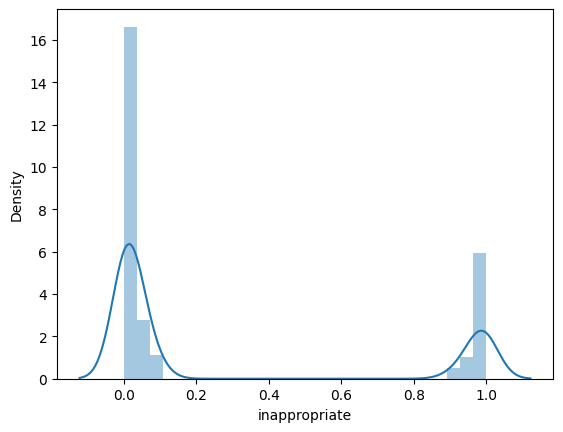

In [4]:
import seaborn as sns 
sns.distplot(df['inappropriate'])

In [30]:
df = pd.read_csv(data_path)
df.rename({'inappropriate': 'target'}, axis=1, inplace=True)
df['target'] = (df['target'] >= 0.5).astype(int)

TEST_SIZE = 0.1

train_df, test_df = train_test_split(df, test_size=TEST_SIZE)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_text = train_df['text'].astype(str)
train_labels = train_df['target']

test_text = test_df['text'].astype(str)
test_labels = test_df['target']

In [53]:
df['target'].value_counts()

target
0    91448
1    33149
Name: count, dtype: int64

In [31]:
len(train_text), len(train_labels), len(test_text), len(test_labels)

(112137, 112137, 12460, 12460)

In [32]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        
seed_all(42)

In [33]:
# # pip install transformers sentencepiece
# import torch
# from transformers import AutoTokenizer, AutoModel
# tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
# model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
# # model.cuda()  # uncomment it if you have a GPU

In [34]:
# model = BertForSequenceClassification.from_pretrained('rubert_base_cased_sentence/', num_labels=2).to("cuda")
# tokenizer = BertTokenizer.from_pretrained('rubert_base_cased_sentence/')

model = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny2', num_labels=2).to("cuda")
tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny2')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
seq_len_train = [len(str(i).split()) for i in train_df['text']]
seq_len_test = [len(str(i).split()) for i in test_df['text']]
max_seq_len = min(512, max(max(seq_len_test), max(seq_len_train)))
max_seq_len

512

In [36]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.values,
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.values,
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)

In [37]:
class Data(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item
    def __len__(self):
        return len(self.labels)
    
train_dataset = Data(tokens_train, train_labels)
test_dataset = Data(tokens_test, test_labels)

In [38]:
len(train_dataset), len(test_dataset)

(112137, 12460)

In [39]:
from sklearn.metrics import f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds)
    return {'F1': f1}

In [46]:
training_args = TrainingArguments(
    output_dir = './results', #Выходной каталог
    num_train_epochs = 1, # 3, #Кол-во эпох для обучения
    per_device_train_batch_size = 8, #Размер батча для каждого устройства во время обучения
    per_device_eval_batch_size = 8, #Размер батча для каждого устройства во время валидации
    weight_decay = 0.01, # регуляризация
    logging_dir = './logs', # Каталог для хранения логов
    report_to = 'tensorboard',
    load_best_model_at_end = True, # Загружать ли лучшую модель после обучения
    learning_rate = 1e-5, # Скорость обучения
    evaluation_strategy ='epoch', #Валидация после каждой эпохи (можно сделать после конкретного кол-ва шагов)
    logging_strategy = 'epoch', #Логирование после каждой эпохи
    save_strategy = 'epoch', #Сохранение после каждой эпохи
    save_total_limit = 1,
    seed=21)

In [47]:
trainer = Trainer(model=model,
                  tokenizer = tokenizer,
                  args = training_args,
                  train_dataset = train_dataset,
                  eval_dataset = train_dataset,
                  compute_metrics = compute_metrics)

In [48]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.414500,0.373201,0.669001


TrainOutput(global_step=7009, training_loss=0.41447038796101443, metrics={'train_runtime': 1106.9035, 'train_samples_per_second': 101.307, 'train_steps_per_second': 6.332, 'total_flos': 826921447667712.0, 'train_loss': 0.41447038796101443, 'epoch': 1.0})

In [49]:
model_path = "fine-tune-bert"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('fine-tune-bert/tokenizer_config.json',
 'fine-tune-bert/special_tokens_map.json',
 'fine-tune-bert/vocab.txt',
 'fine-tune-bert/added_tokens.json')

In [50]:
def get_prediction():
    test_pred = trainer.predict(test_dataset)
    labels = np.argmax(test_pred.predictions, axis = -1)
    return labels
pred = get_prediction()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [51]:
print(classification_report(test_labels, pred))
print(f1_score(test_labels, pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      9184
           1       0.65      0.60      0.63      3276

    accuracy                           0.81     12460
   macro avg       0.76      0.74      0.75     12460
weighted avg       0.81      0.81      0.81     12460

0.6259930092151255


## RAG

Для того, чтобы проверить как работает предобученный RAG, стоит перенестисть в локальную среду разработки - данная реализация RAG использует быстрый поиск ближайших соседей и опирается на библиотеку faiss, которая использует c++ и требовательна к соответствующему окружению. 

Для локальной установки через конду / миниконду:
    
Если на cpu: conda install -c pytorch faiss-cpu=1.7.4 mkl=2021 blas=1.0=mkl
    
Если есть gpu: conda install -c pytorch -c nvidia faiss-gpu=1.7.4 mkl=2021 blas=1.0=mkl

In [1]:
from transformers import RagTokenizer, RagRetriever, RagTokenForGeneration

tokenizer = RagTokenizer.from_pretrained("facebook/rag-token-nq")
retriever = RagRetriever.from_pretrained("facebook/rag-token-nq", index_name="exact", use_dummy_dataset=True)
model = RagTokenForGeneration.from_pretrained("facebook/rag-token-nq", retriever=retriever)

input_dict = tokenizer.prepare_seq2seq_batch("who holds the record in 100m freestyle", return_tensors="pt") 

generated = model.generate(input_ids=input_dict["input_ids"]) 
print(tokenizer.batch_decode(generated, skip_special_tokens=True)[0]) 

# should give michael phelps => sounds reasonable

/Users/d.kalashnikov/opt/anaconda3/envs/research/lib/python3.8/site-packages/transformers/models/bart/configuration_bart.py:179: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this func

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/d.kalashnikov/opt/anaconda3/envs/research/lib/python3.8/site-packages/transformers/models/bart/configuration_bart.py:179: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


Some weights of the model checkpoint at facebook/rag-token-nq were not used when initializing RagTokenForGeneration: ['rag.question_encoder.question_encoder.bert_model.pooler.dense.bias', 'rag.question_encoder.question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing RagTokenForGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RagTokenForGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/d.kalashnikov/opt/anaconda3/envs/research/lib/python3.8/site-packages/transformers/models/rag/tokenization_rag.py:87: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method

 michael phelps
